In [1]:
import warnings
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn import metrics
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix

### pobieramy potrzebne biblioteki

### autorzy: Adrian Bloch i Witold Jagiełło

In [2]:
warnings.filterwarnings("ignore")

### ignorujemy ostrzeżenia

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### jeśli dostępny jest procesor graficzny to go wykorzystaj inaczej użyj procesora

In [4]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False,
                                             transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



### ładujemy dane z pliku potem zamieniamy je na tensory PyTorch

In [5]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


### 10 rodzajów ubrań, zwraca odpowiednią wartość

In [6]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

### określamy zwracany element(obraz)

In [7]:
batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


### przycinamy dane dla prawidłowego formatu

labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

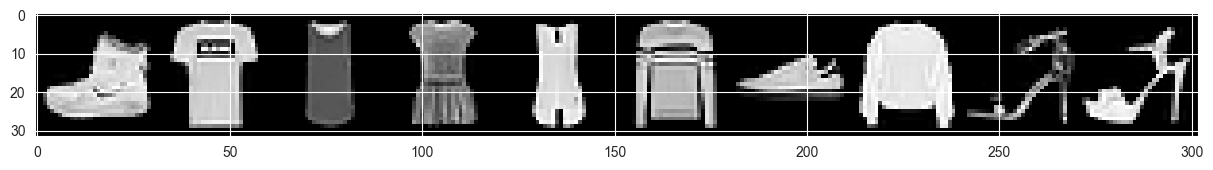

In [8]:
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")
plt.show()

### wyświetlamy

In [9]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        """Linear - "Stosuje transformację liniową do przychodzących danych"""""
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        """Dropout2d - Wyzerowywuje losowe kanały z prawdpodobieństwem 0.25"""
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

### Tworzymy klasę FashionCNN, sieć neuronową dwuwarstwową

In [10]:

model = FashionCNN()
"""Transfer na GPU jeśli możliwe"""
model.to(device)
"""Definiowanie funkcji straty. używamy tutaj CrossEntropyLoss() - To kryterium oblicza krzyżową utratę entropii między logami wejściowymi a celem."""
error = nn.CrossEntropyLoss()

### Tworzymy obiekt

In [11]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


### korzystamy z algorytmu Adama i wyswietlamy

In [12]:

num_epochs = 5
count = 0
"""Listy do wizualizacji strat i dokładności"""
loss_list = []
iteration_list = []
accuracy_list = []

"""Listy do poznania dokładności klasowej"""
predictions_list = []
labels_list = []


### uczymy i testujemy sieć oraz tworzymy listy strat i dokładności

In [ ]:
for epoch in range(num_epochs):
    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass
        outputs = model(train)
        loss = error(outputs, labels)

        optimizer.zero_grad()

        loss.backward()


        optimizer.step()

        count += 1


        if not (count % 50):  # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


### testujemy model

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

### Pokazujemy straty i dokładności

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")

plt.show()

### ilość iteracji i ich skuteczność

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]


### ile z nich było prawidłowych

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

"""Drukowanie matrycy zamieszania - confisuion matrix"""
predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

### wypisanie dokładności oraz drukowanie "confusion matrix"